<a href="https://colab.research.google.com/github/MIlhamEr/Skripsi/blob/main/Bobot%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reading Dataset

## ADRO

In [ ]:
url_adro = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Adaro%20Energy%20Indonesia%20Tbk_2020-2024.csv"
adro = pd.read_csv(url_adro)
adro.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1555.0,1555.0,1490.0,1495.0,835.632202,76612000
1,2020-01-03,1460.0,1470.0,1425.0,1465.0,856.372375,117795600
2,2020-01-06,1455.0,1515.0,1450.0,1465.0,856.372375,61423200
3,2020-01-07,1480.0,1540.0,1460.0,1540.0,900.213867,74336500
4,2020-01-08,1530.0,1535.0,1505.0,1505.0,879.754395,55121100


In [ ]:
adro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


## DSSA

In [ ]:
url_dssa = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Dian%20Swastatika%20Sentosa%20Tbk_2020-2024.csv"
dssa = pd.read_csv(url_dssa)
dssa.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1360.0,1435.0,1360.0,1435.0,1435.0,5000
1,2020-01-03,1435.0,1435.0,1435.0,1435.0,1435.0,0
2,2020-01-06,1437.5,1437.5,1435.0,1435.0,1435.0,3000
3,2020-01-07,1435.0,1435.0,1435.0,1435.0,1435.0,0
4,2020-01-08,1435.0,1435.0,1435.0,1435.0,1435.0,0


In [ ]:
dssa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


# Pre-processing Data

## Normalisasi Data

*   Normalisasi data adro pake MinMaxScaler karena distribusinya normal
*   Normalisasi data dssa pake StandardScaler karena terdapat outlier
*   Kolom Date Ga dipake

In [ ]:
scaler = MinMaxScaler()

In [ ]:
def normalize_data(df):
    scaled_df = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:], index=df.index)
    return scaled_df

In [ ]:
adro_norm = adro.copy()
adro_norm = normalize_data(adro_norm)
adro_norm = adro_norm.drop('Volume', axis=1)
adro_norm.head()

,Open,High,Low,Close,Adj Close
0,0.260372,0.247207,0.253602,0.243205,0.129805
1,0.233190,0.223464,0.234870,0.234621,0.135675
2,0.231760,0.236034,0.242075,0.234621,0.135675
3,0.238913,0.243017,0.244957,0.256080,0.148084
4,0.253219,0.241620,0.257925,0.246066,0.142293


In [ ]:
dssa_norm = dssa.copy()
dssa_norm = normalize_data(dssa_norm)
dssa_norm = dssa_norm.drop('Volume', axis=1)
dssa_norm.head()

,Open,High,Low,Close,Adj Close
0,0.010859,0.011743,0.011073,0.012575,0.012575
1,0.012669,0.011743,0.012918,0.012575,0.012575
2,0.012729,0.011800,0.012918,0.012575,0.012575
3,0.012669,0.011743,0.012918,0.012575,0.012575
4,0.012669,0.011743,0.012918,0.012575,0.012575


## Windowing (Time Series Data)

Data look back yaitu adalah data yang biasanya dipakai untuk tipe time series, data ini menjadikan nilai lookback+1 sebagai nilai prediksi , dan data lookbacknya sebagai fitur.Ini berlaku untuk seluruh data, contoh penggambarannya seperti pada gambar diatas

In [ ]:
def prepare_data(df, time_step):
    X, y = [], []
    for i in range(len(df)-time_step):
        t = []
        for j in range(time_step):
            t.append(df.iloc[i + j].values)  # Use all columns for features
        X.append(t)
        y.append(df['High'][i + time_step]) # Predict High price
    return np.array(X), np.array(y)

In [ ]:
time_step = 7
X_adro, y_adro = prepare_data(adro_norm, time_step)

In [ ]:
print(X_adro[1])
print(y_adro[1])

[[0.23319027 0.22346369 0.23487032 0.23462089 0.13567503]
 [0.23175966 0.23603352 0.24207493 0.23462089 0.13567503]
 [0.23891273 0.24301676 0.24495677 0.25608011 0.1480843 ]
 [0.25321888 0.24162011 0.25792507 0.24606581 0.14229328]
 [0.25035765 0.23882682 0.24927954 0.24320458 0.14063873]
 [0.25035765 0.25       0.26080692 0.25894134 0.14973887]
 [0.26895565 0.25837989 0.27233429 0.26323319 0.15222076]]
0.2555865921787709


In [ ]:
X_adro.shape, y_adro.shape

((1141, 7, 5), (1141,))

In [ ]:
X_dssa, y_dssa = prepare_data(dssa_norm, time_step)

## Split data into training and testing sets

In [ ]:
X_train_adro, X_test_adro, y_train_adro, y_test_adro = train_test_split(X_adro, y_adro, test_size=0.2, random_state=42, shuffle=False)
X_train_dssa, X_test_dssa, y_train_dssa, y_test_dssa = train_test_split(X_dssa, y_dssa, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
X_train_adro.shape, X_test_adro.shape, y_train_adro.shape, y_test_adro.shape

((912, 7, 5), (229, 7, 5), (912,), (229,))

# Data Mining

In [ ]:
def create_lstm_model(units):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_adro.shape[1], X_train_adro.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for single prediction (predicted stock price)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Bobot LSTM

In [ ]:
# Create model
lstm_model = create_lstm_model(50)  # Example: 50 LSTM units

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
layer = lstm_model.layers[0]  # Ambil hanya layer pertama
if isinstance(layer, LSTM):
    weights = layer.get_weights()
    # W: Input weights, U: Recurrent weights, b: Bias
    W, U, b = weights[0], weights[1], weights[2]
    units = U.shape[0]  # Jumlah unit LSTM
    columns = ["Open", "High", "Low", "Close", "Adj Close"]
    num_features = len(columns)

    # Memisahkan bobot untuk setiap gate
    W_f, W_i, W_c, W_o = np.split(W, 4, axis=1)
    U_f, U_i, U_c, U_o = np.split(U, 4, axis=1)
    b_f, b_i, b_c, b_o = np.split(b, 4, axis=0)

    print("LSTM Layer 1 Weights Analysis:")
    for i in range(num_features):  # Iterasi sesuai jumlah fitur
        print(f"Feature: {columns[i]}")
        print(f"  Forget Gate W_f[{i}, 0]: {W_f[i, 0]}")
        print(f"  Input Gate W_i[{i}, 0]: {W_i[i, 0]}")
        print(f"  Cell State W_c[{i}, 0]: {W_c[i, 0]}")
        print(f"  Output Gate W_o[{i}, 0]: {W_o[i, 0]}")
        print(f"  Forget Gate U_f[{i}, 0]: {U_f[i, 0]}")
        print(f"  Input Gate U_i[{i}, 0]: {U_i[i, 0]}")
        print(f"  Cell State U_c[{i}, 0]: {U_c[i, 0]}")
        print(f"  Output Gate U_o[{i}, 0]: {U_o[i, 0]}")
        print(f"  Forget Gate b_f[{i}]: {b_f[i]}")
        print(f"  Input Gate b_i[{i}]: {b_i[i]}")
        print(f"  Cell State b_c[{i}]: {b_c[i]}")
        print(f"  Output Gate b_o[{i}]: {b_o[i]}")
        print("====")

LSTM Layer 1 Weights Analysis:
Feature: Open
  Forget Gate W_f[0, 0]: -0.058409683406353
  Input Gate W_i[0, 0]: -0.057416193187236786
  Cell State W_c[0, 0]: -0.11301811039447784
  Output Gate W_o[0, 0]: -0.10661923885345459
  Forget Gate U_f[0, 0]: -0.0015834569931030273
  Input Gate U_i[0, 0]: -0.05439761281013489
  Cell State U_c[0, 0]: 0.1868397295475006
  Output Gate U_o[0, 0]: -0.0036565163172781467
  Forget Gate b_f[0]: 0.0
  Input Gate b_i[0]: 1.0
  Cell State b_c[0]: 0.0
  Output Gate b_o[0]: 0.0
====
Feature: High
  Forget Gate W_f[1, 0]: -0.012069299817085266
  Input Gate W_i[1, 0]: 0.09539869427680969
  Cell State W_c[1, 0]: 0.09283101558685303
  Output Gate W_o[1, 0]: -0.015658587217330933
  Forget Gate U_f[1, 0]: -0.004188260063529015
  Input Gate U_i[1, 0]: 0.027675429359078407
  Cell State U_c[1, 0]: -0.046433210372924805
  Output Gate U_o[1, 0]: -0.0413055382668972
  Forget Gate b_f[1]: 0.0
  Input Gate b_i[1]: 1.0
  Cell State b_c[1]: 0.0
  Output Gate b_o[1]: 0.0
==

## ADRO

In [ ]:
model_adro = create_lstm_model(100)

start_time = time.time()
model_adro.fit(X_train_adro, y_train_adro, epochs=100, batch_size=32, validation_split=0.1)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Waktu training: {elapsed_time:.2f} detik")

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0692 - val_loss: 0.0064
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - val_loss: 7.4306e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

In [ ]:
model_adro.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 7, 100)         │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,705 (1.41 MB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 245,804 (960.18 KB)

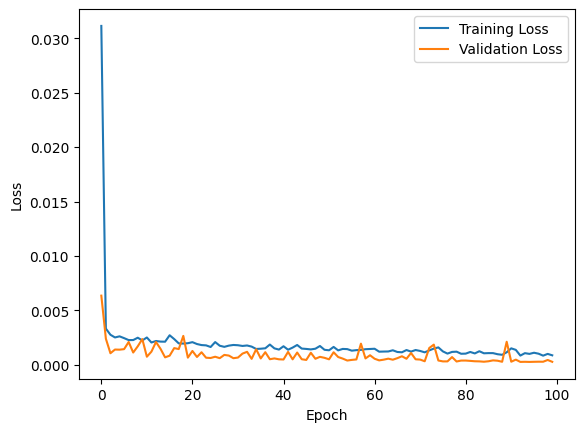

In [ ]:
plt.plot(model_adro.history.history['loss'], label='Training Loss')
plt.plot(model_adro.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Make predictions

In [ ]:
y_pred_adro = model_adro.predict(X_test_adro)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


## DSSA

In [ ]:
model_dssa = create_lstm_model(100)

start_time = time.time()
model_dssa.fit(X_train_dssa, y_train_dssa, epochs=50, batch_size=32, validation_split=0.1)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Waktu training: {elapsed_time:.2f} detik")

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0012 - val_loss: 2.1616e-05
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5971e-05 - val_loss: 3.2522e-05
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8720e-05 - val_loss: 2.0585e-05
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8901e-05 - val_loss: 2.3072e-05
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2381e-05 - val_loss: 2.9332e-05
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3647e-05 - val_loss: 2.3457e-05
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0865e-05 - val_loss: 2.2256e-05
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0819e-05 - val_loss: 3.1051e-05
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1795e-05 - val_loss: 1.9674e-05
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7146e-05 - val_loss: 2.8758e-05
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6881e-05 - va

In [ ]:
model_dssa.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 7, 100)         │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,705 (1.41 MB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 245,804 (960.18 KB)

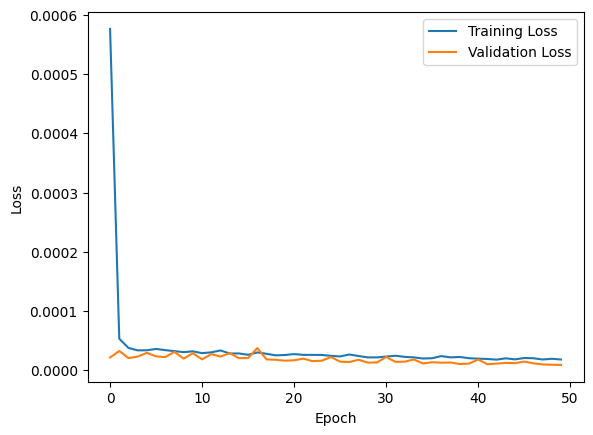

In [ ]:
plt.plot(model_dssa.history.history['loss'], label='Training Loss')
plt.plot(model_dssa.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Make predictions

In [ ]:
y_pred_dssa = model_dssa.predict(X_test_dssa)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


## Evaluate Model

In [ ]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R-squared: {r2:.5f}')

    return rmse, mape, r2

In [ ]:
# Evaluate ADRO model
print("Evaluation for ADRO:")
rmse_adro, mape_adro, r2_adro = evaluate_model(y_test_adro, y_pred_adro)

# Evaluate DSSA model
print("\nEvaluation for DSSA:")
rmse_dssa, mape_dssa, r2_dssa = evaluate_model(y_test_dssa, y_pred_dssa)

Evaluation for ADRO:
RMSE: 0.018
MAPE: 17.537%
R-squared: 0.96905

Evaluation for DSSA:
RMSE: 0.042
MAPE: 115.220%
R-squared: 0.97830


## Plot the predicted vs actual values

In [ ]:
def plot_predictions(y_true, y_pred, title, bgcolor='#f8f4f4', figcolor='#f8f4f4'):
    plt.figure(figsize=(16, 4), facecolor=figcolor)
    ax = plt.gca()
    ax.set_facecolor(bgcolor)

    plt.plot(y_true, label='Actual Price', color='orange')
    plt.plot(y_pred, label='Predicted Price', color='green')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.gca().set_facecolor(bgcolor)

    plt.show()

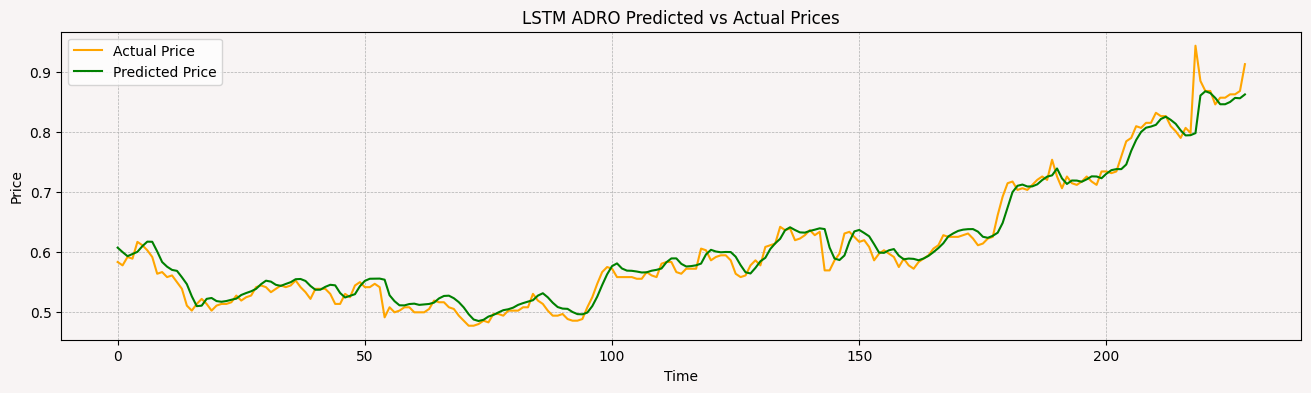

In [ ]:
# Plot ADRO predictions
plot_predictions(y_test_adro, y_pred_adro, 'LSTM ADRO Predicted vs Actual Prices')

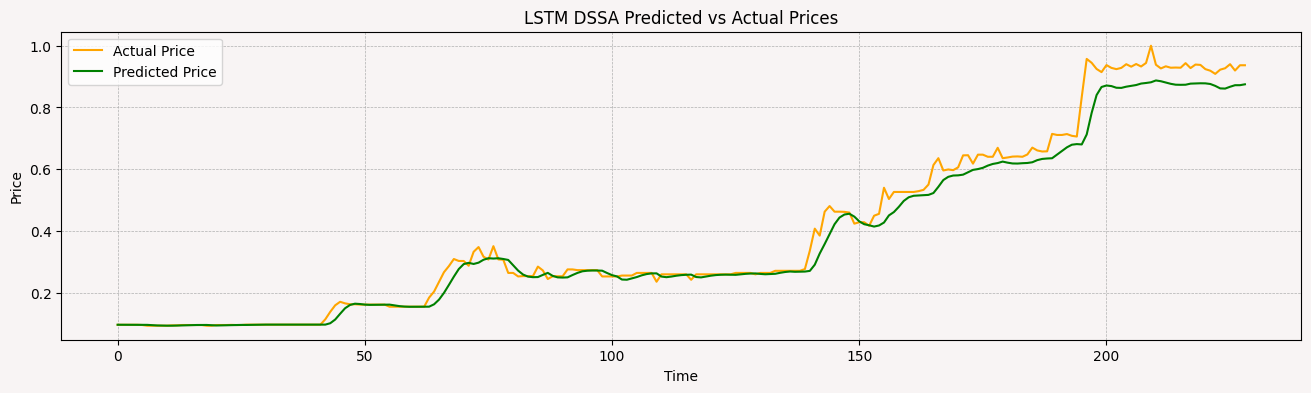

In [ ]:
plot_predictions(y_test_dssa, y_pred_dssa, 'LSTM DSSA Predicted vs Actual Prices')